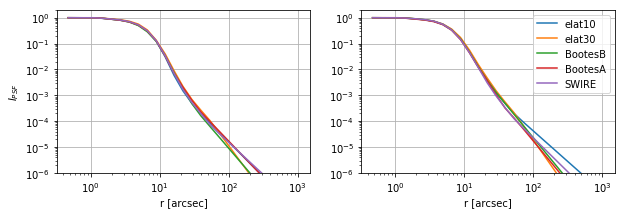

In [11]:
# plot the PSF model
from run_fit import *

im = 3
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for ifield in [4,5,6,7,8]:
    param_fit = fit_stacking_mcmc(1, ifield, im)
    ax[0].loglog(param_fit.rfull_arr, param_fit.profpsf_arr)
    param_fit = fit_stacking_mcmc(2, ifield, im)
    ax[1].loglog(param_fit.rfull_arr, param_fit.profpsf_arr,label=param_fit.field)

ax[0].set_ylim([1e-6,2])
ax[1].set_ylim([1e-6,2])
ax[0].set_xlabel('r [arcsec]')
ax[1].set_xlabel('r [arcsec]')
ax[0].set_ylabel(r'$I_{PSF}$')
ax[1].legend(fontsize=10)
ax[0].grid()
ax[1].grid()

## plot data with fiducial W19 model

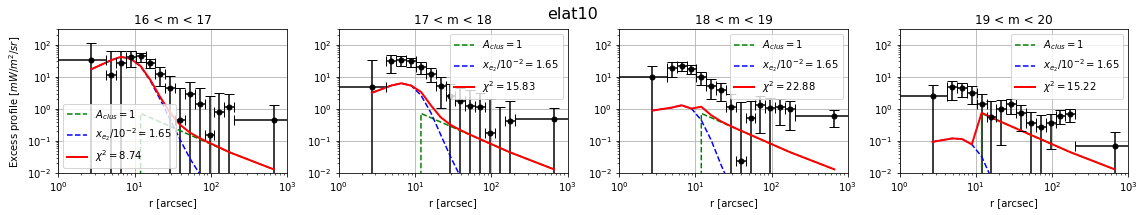

In [1]:
#
from run_fit import *

inst = 1
ifield = 4

fig, ax = plt.subplots(1, 4, figsize = (16,3))
for im in range(4):
    W19_params = gal_profile_model().Wang19_params(im)
    xe2 = W19_params['sersic2'][2]
    param_fit = fit_stacking_mcmc(inst, ifield, im)
    r_arr = param_fit.r_arr
    profd_arr = param_fit.profd_arr
    profd_err = param_fit.profd_err_diag
    profclus_arr = param_fit.profclus_arr
    profex_arr = param_fit.get_profexcess_model()
    chi2 = param_fit.get_chi2()
    rbinedges = profile_rbinedges(r_arr)
    
    ax[im].loglog(r_arr, profclus_arr,'g--', label = '$A_{clus}=$%d'%1)
    ax[im].loglog(r_arr, profex_arr,'b--', label = '$x_{e_2}/10^{-2}=$%.2f'%(xe2/1e-2))
    ax[im].loglog(r_arr, profex_arr + profclus_arr,'r-', lw=2,
                 label = '$\chi^2=$%.2f'%chi2)
    ax[im].errorbar(r_arr, profd_arr, profd_err, 
                    [r_arr - rbinedges[:-1], rbinedges[1:] - r_arr],
                 fmt='.', color='k',capsize=5, markersize=10)
    ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max))
    ax[im].set_ylim([1e-2,3e2])
    ax[im].set_xlim([1e0,1e3])
    ax[im].grid()
    ax[im].legend()
    ax[im].set_xlabel('r [arcsec]')
ax[0].set_ylabel('Excess profile [$mW/m^2/sr$]')
fig.suptitle(fieldnamedict[ifield], fontsize=16)

plt.tight_layout()
# plt.savefig('plots/profile_fiducial_%s.png'%param_fit.field, dpi = 150)

## MCMC best fit

how to find the best fit combination of param??

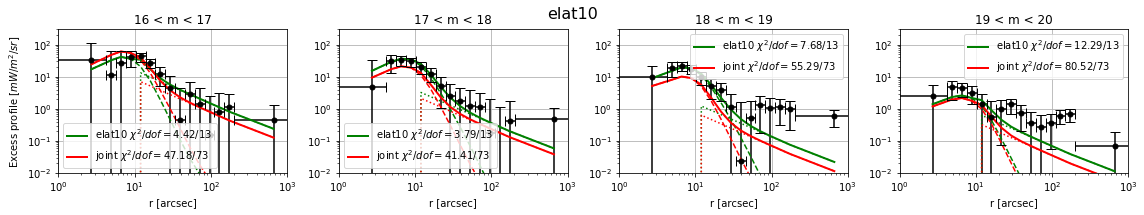

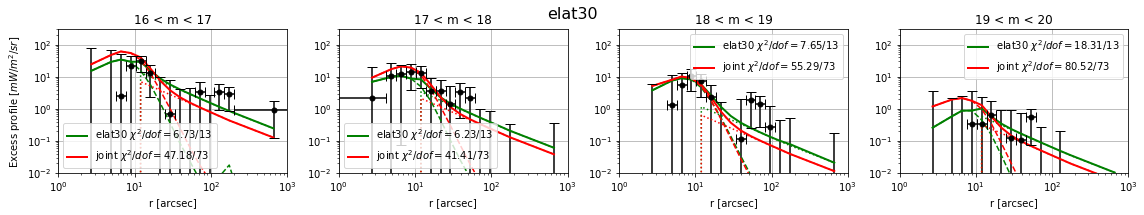

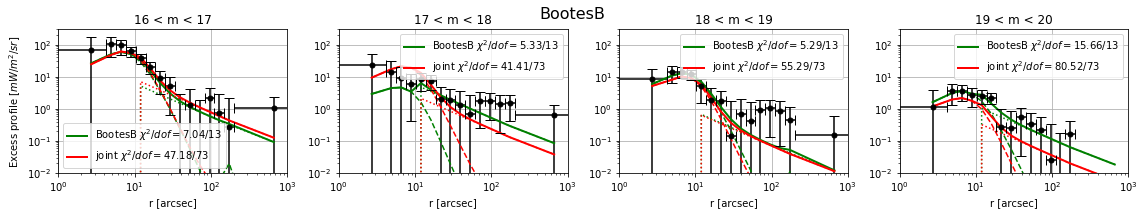

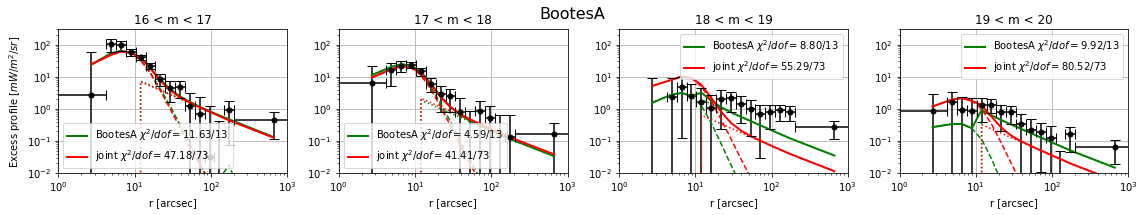

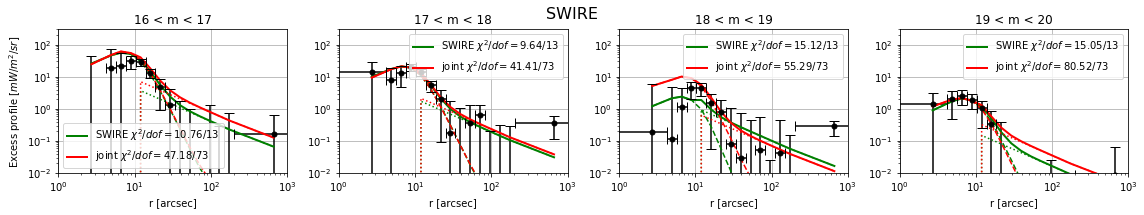

In [67]:
#
from run_fit import *

inst = 1

Aclus_joint = []
profex_arr_joint = []
chi2_joint = []
for im in range(4):
    W19_params = gal_profile_model().Wang19_params(im)
    param_fit = fit_stacking_mcmc(inst, 4, im)
    savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
    savename = 'mcmc_2par_joint' + \
    '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
    samples = np.load(savedir + savename)
    flatsamps = samples.copy()
    flatsamps = flatsamps[100:,:,:].reshape((-1,2))

    xe2, Aclus = np.median(flatsamps, axis=0)
    profex_arr = param_fit.get_profexcess_model(xe2=xe2)
    Aclus_joint.append(Aclus)
    profex_arr_joint.append(profex_arr)
    chi2 = joint_fit_mcmc(inst,im).get_chi2(xe2=xe2, Aclus=Aclus)
    chi2_joint.append(chi2)

for ifield in [4,5,6,7,8]:
    fig, ax = plt.subplots(1, 4, figsize = (16,3))
    for im in range(4):
        W19_params = gal_profile_model().Wang19_params(im)
        param_fit = fit_stacking_mcmc(inst, ifield, im)
        savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
        savename = 'mcmc_2par_' + param_fit.field + \
        '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        samples = np.load(savedir + savename)
        flatsamps = samples.copy()
        flatsamps = flatsamps[100:,:,:].reshape((-1,2))

        xe2, Aclus = np.median(flatsamps, axis=0)

        r_arr = param_fit.r_arr
        profd_arr = param_fit.profd_arr
        profd_err = param_fit.profd_err_diag
        profclus_arr = param_fit.profclus_arr
        profex_arr = param_fit.get_profexcess_model(xe2=xe2)
        chi2 = param_fit.get_chi2(xe2=xe2, Aclus=Aclus)
        rbinedges = profile_rbinedges(r_arr)

        ax[im].loglog(r_arr, Aclus*profclus_arr,'g:')#, label = '$A_{clus}=$%.2f'%Aclus)
        ax[im].loglog(r_arr, profex_arr,'g--')#, label = '$x_{e_2}/10^{-2}=$%.2f'%(xe2/1e-2))
        ax[im].loglog(r_arr, profex_arr + Aclus*profclus_arr,'g-', lw=2,
                     label = fieldnamedict[ifield] + ' $\chi^2/dof=$%.2f/13'%chi2)
        ax[im].loglog(r_arr, Aclus_joint[im]*profclus_arr,'r:')
        ax[im].loglog(r_arr, profex_arr_joint[im],'r--')
        ax[im].loglog(r_arr, profex_arr_joint[im] + Aclus_joint[im]*profclus_arr,'r-', lw=2,
                     label = 'joint'+' $\chi^2/dof=$%.2f/73'%chi2_joint[im])
        
        ax[im].errorbar(r_arr, profd_arr, profd_err, 
                        [r_arr - rbinedges[:-1], rbinedges[1:] - r_arr],
                     fmt='.', color='k',capsize=5, markersize=10)
        ax[im].errorbar(r_arr, -profd_arr, profd_err, 
                [r_arr - rbinedges[:-1], rbinedges[1:] - r_arr],
             fmt='.', mfc='white', color='k',capsize=5, markersize=10)
        ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max))
        ax[im].set_ylim([1e-3,3e2])
        ax[im].set_xlim([1e0,1e3])
        ax[im].grid()
        ax[im].legend()
        ax[im].set_xlabel('r [arcsec]')
    ax[0].set_ylabel('Excess profile [$mW/m^2/sr$]')
    fig.suptitle(fieldnamedict[ifield], fontsize=16)

    plt.tight_layout()
    plt.savefig('plots/profile_best_%s.png'%param_fit.field, dpi = 150)

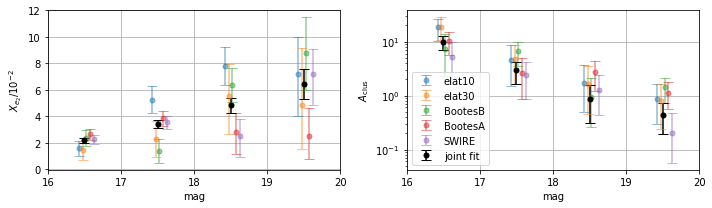

In [54]:
#
from run_fit import *

inst = 1

fig, ax = plt.subplots(1, 2, figsize = (10,3))
for ifield in [4,5,6,7,8,0]:
    xoff = 0 if ifield==0 else (ifield-5.5)*0.05
    m_arr = np.zeros(4)
    xe2_arr = np.zeros(4)
    Aclus_arr = np.zeros(4)
    xe2_low_arr = np.zeros(4)
    Aclus_low_arr = np.zeros(4)
    xe2_high_arr = np.zeros(4)
    Aclus_high_arr = np.zeros(4)
    for im in range(4):
        if ifield == 0:
            param_fit = fit_stacking_mcmc(inst, 4, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_joint'+ \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        else:     
            param_fit = fit_stacking_mcmc(inst, ifield, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_' + param_fit.field + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        samples = np.load(savedir + savename)
        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * 1e2
        flatsamps = flatsamps[100:,:,:].reshape((-1,2))

        xe2, Aclus = np.median(flatsamps, axis=0)
        xe2_low, Aclus_low = np.percentile(flatsamps, 16, axis=0)
        xe2_high, Aclus_high = np.percentile(flatsamps, 84, axis=0)
        
        xe2_arr[im] = xe2
        Aclus_arr[im] = Aclus
        xe2_low_arr[im] = xe2_low
        Aclus_low_arr[im] = Aclus_low
        xe2_high_arr[im] = xe2_high
        Aclus_high_arr[im] = Aclus_high

        m_arr[im] = (param_fit.m_min + param_fit.m_max)/2
    
    if ifield == 0:
        ax[0].errorbar(m_arr+xoff, xe2_arr, [xe2_arr - xe2_low_arr, xe2_high_arr - xe2_arr],
                      fmt='.', capsize=5, markersize=10, c='k')
        ax[1].errorbar(m_arr+xoff, Aclus_arr, [Aclus_arr - Aclus_low_arr, Aclus_high_arr - Aclus_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
    else:
        ax[0].errorbar(m_arr+xoff, xe2_arr, [xe2_arr - xe2_low_arr, xe2_high_arr - xe2_arr],
                      fmt='.', capsize=5, markersize=10, alpha = 0.5)
        ax[1].errorbar(m_arr+xoff, Aclus_arr, [Aclus_arr - Aclus_low_arr, Aclus_high_arr - Aclus_arr],
                      fmt='.', capsize=5, markersize=10, label = param_fit.field, alpha = 0.5)

ax[1].legend()
ax[0].set_xlabel('mag')
ax[0].set_ylabel(r"$X_{e_2}/10^{-2}$")
ax[1].set_xlabel('mag')
ax[1].set_ylabel(r"$A_{\rm clus}$")
ax[1].set_yscale('log')
ax[0].set_xticks([16,17,18,19,20])
ax[1].set_xticks([16,17,18,19,20])
ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.savefig('plots/params_best.png', dpi = 150)

## plot the chains

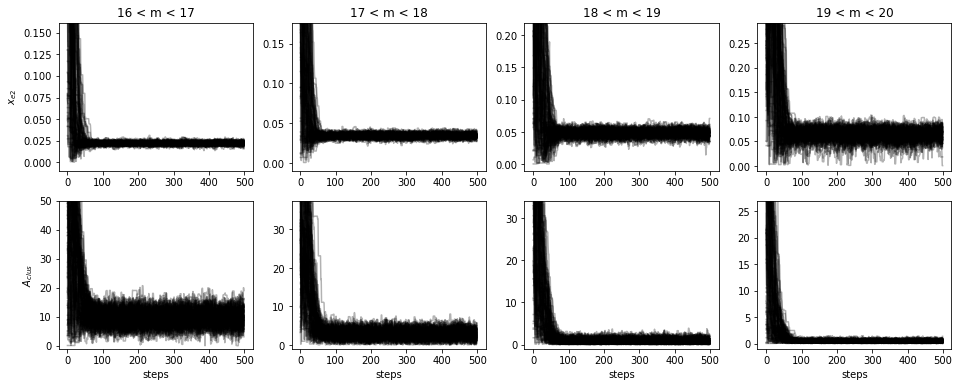

In [30]:
from run_fit import *
def plot_chains(inst, ifield=None):
    fig, ax = plt.subplots(2,4, figsize=(16,6))
    
    for im in range(4):
        W19_params = gal_profile_model().Wang19_params(im)
        
        if ifield is None:
            param_fit = fit_stacking_mcmc(inst, 4, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_joint'+ \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        else:     
            param_fit = fit_stacking_mcmc(inst, ifield, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_' + param_fit.field + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        for i in range(nwalkers):
            ax[0][im].plot(samples[:,i,0], "k", alpha=0.3)
            ax[1][im].plot(samples[:,i,1], "k", alpha=0.3)

        med = np.median(samples[:,:,0])
        std = np.std(samples[:,:,0])
        ax[0][im].set_ylim([-0.01, med+2*std])
        ax[0][im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max))

        med = np.median(samples[:,:,1])
        std = np.std(samples[:,:,1])
        ax[1][im].set_ylim([-1, med+4*std])
        ax[1][im].set_xlabel('steps')

    ax[0][0].set_ylabel('$x_{e2}$')
    ax[1][0].set_ylabel('$A_{clus}$')
plot_chains(1)

## MCMC corner plots

In [77]:
from run_fit import *
import corner

inst = 1

for ifield in [0,4,5,6,7,8]:
    if ifield==0:
        truths_arr = []
    for im in range(4):
        if ifield==0:
            param_fit = fit_stacking_mcmc(inst, 4, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_joint' + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        else:
            param_fit = fit_stacking_mcmc(inst, ifield, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_' + param_fit.field + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * 1e2
        flatsamps = flatsamps[100:,:,:].reshape((-1,2))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        
        if ifield==0:
            truths_arr.append(np.median(flatsamps, axis=0))

        levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,12),(0,20)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$X_{e_2}/10^{-2}$", r"$A_{\rm clus}$"],
                               truths=truths_arr[im])
        if ifield==0:
            plt.savefig('plots/mcmc_joint_m%d_%d.png'\
                        %(param_fit.m_min, param_fit.m_max), dpi=150)
        else:
            plt.savefig('plots/mcmc_%s_m%d_%d.png'\
                        %(param_fit.field, param_fit.m_min, param_fit.m_max), dpi=150)

        plt.close()

In [18]:
# combine four mag plots into one plot
from run_fit import *
from PIL import Image
import os

for ifield in [0,4,5,6,7,8]:
    result = Image.new("RGB", (3200,800))    
    for im in range(4):
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/mcmc_%s_m%d_%d.png'\
                        %(fieldname, im+16, im+17)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = im * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
    
    result.save(os.path.expanduser('plots/mcmc_%s.png'%fieldname)) 

# Joint fit & averaged excess profile

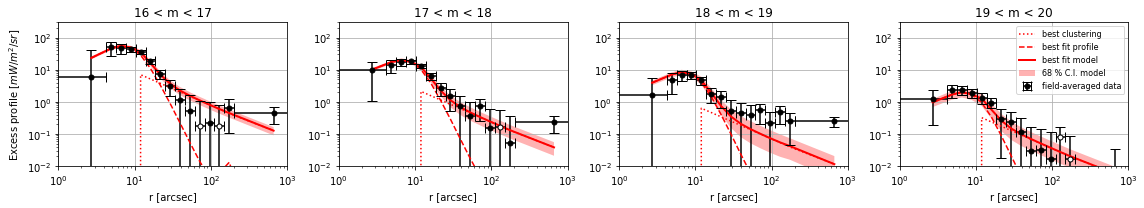

In [6]:
#
from run_fit import *

inst = 1
fig, ax = plt.subplots(1, 4, figsize = (16,3))
for im in range(4):
    param_fit = fit_stacking_mcmc(inst, 4, im)
    savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
    savename = 'mcmc_2par_joint'+ \
    '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
    samples = np.load(savedir + savename)
    flatsamps = samples.copy()
    flatsamps[:,:,0] = flatsamps[:,:,0]
    flatsamps = flatsamps[100:,:,:].reshape((-1,2))

    xe2, Aclus = np.median(flatsamps, axis=0)
    xe2_low, Aclus_low = np.percentile(flatsamps, 16, axis=0)
    xe2_high, Aclus_high = np.percentile(flatsamps, 84, axis=0)
    
    profd_arr, profd_err, profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0, 0, 0
    for ifield in [4,5,6,7,8]:
        W19_params = gal_profile_model().Wang19_params(im)
        param_fit = fit_stacking_mcmc(inst, ifield, im)

        profd_arri = param_fit.profd_arr
        profd_erri = param_fit.profd_err_diag
        profex_arri = param_fit.get_profexcess_model(xe2=xe2)
        profex_arr += profex_arri
        profex_arri_low = param_fit.get_profexcess_model(xe2=xe2_low)
        profex_arr_low += profex_arri_low
        profex_arri_high = param_fit.get_profexcess_model(xe2=xe2_high)
        profex_arr_high += profex_arri_high
        
        profd_arr += profd_arri / profd_erri**2
        profd_err += 1 / profd_erri**2
        
    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    profd_arr /= profd_err
    profd_err = np.sqrt(1 / profd_err)
    
    r_arr = param_fit.r_arr
    rbinedges = profile_rbinedges(r_arr)
    profclus_arr = param_fit.profclus_arr

    ax[im].loglog(r_arr, Aclus*profclus_arr,'r:', label='best clustering')
    ax[im].loglog(r_arr, profex_arr,'r--', label='best fit profile')
    ax[im].loglog(r_arr, profex_arr + Aclus*profclus_arr,'r-', lw=2, label='best fit model')
    ax[im].fill_between(r_arr, profex_arr_low + Aclus_low*profclus_arr,
                       profex_arr_high + Aclus_high*profclus_arr, facecolor='r', alpha=0.3,
                       label='68 % C.I. model')
    
    x_err_low = r_arr - rbinedges[:-1]
    x_err_high = rbinedges[1:] - r_arr
    spp = np.where(profd_arr >= 0)[0]
    spn = np.where(profd_arr < 0)[0]
    ax[im].errorbar(r_arr[spp], profd_arr[spp], profd_err[spp], 
                    [x_err_low[spp], x_err_high[spp]],
                 fmt='.', color='k',capsize=5, markersize=10, label='field-averaged data')
    ax[im].errorbar(r_arr[spn], -profd_arr[spn], profd_err[spn], 
                    [x_err_low[spn], x_err_high[spn]],
                 fmt='.', mfc='white', color='k',capsize=5, markersize=10)
    ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max))
    ax[im].set_ylim([1e-2,3e2])
    ax[im].set_xlim([1e0,1e3])
    ax[im].grid()
    ax[im].set_xlabel('r [arcsec]')
ax[im].legend(fontsize=8,loc=1)
ax[0].set_ylabel('Excess profile [$mW/m^2/sr$]')

plt.tight_layout()
plt.savefig('plots/profile_best_joint.png', dpi = 200, bbox_inches='tight')

In [65]:
#
from run_fit import *

helgfname = '/Users/ytcheng/ciber/doc/20170904_External/helgason/Helgason125.txt'
data_helgason = np.loadtxt(helgfname, delimiter=',')

inst = 1
Itot_arr = []
Itot_arr_low = []
Itot_arr_high = []

for im in range(4):
    param_fit = fit_stacking_mcmc(inst, 4, im)
    savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
    savename = 'mcmc_2par_joint'+ \
    '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
    samples = np.load(savedir + savename)
    flatsamps = samples.copy()
    flatsamps[:,:,0] = flatsamps[:,:,0]
    flatsamps = flatsamps[100:,:,:].reshape((-1,2))

    xe2, Aclus = np.median(flatsamps, axis=0)
    xe2_low, Aclus_low = np.percentile(flatsamps, 16, axis=0)
    xe2_high, Aclus_high = np.percentile(flatsamps, 84, axis=0)
    
    dN_dm_ddeg2 = 10**(np.interp((param_fit.m_min + param_fit.m_max) / 2, 
                                 data_helgason[:,0], np.log10(data_helgason[:,1])))

    profd_arr, profd_err, profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0, 0, 0
    for ifield in [4,5,6,7,8]:
        W19_params = gal_profile_model().Wang19_params(im)
        param_fit = fit_stacking_mcmc(inst, ifield, im)

        profd_arri = param_fit.profd_arr
        profd_erri = param_fit.profd_err_diag
        profex_arri = param_fit.get_profexcess_model(xe2=xe2)
        profex_arr += profex_arri
        profex_arri_low = param_fit.get_profexcess_model(xe2=xe2_low)
        profex_arr_low += profex_arri_low
        profex_arri_high = param_fit.get_profexcess_model(xe2=xe2_high)
        profex_arr_high += profex_arri_high
        
        profd_arr += profd_arri / profd_erri**2
        profd_err += 1 / profd_erri**2
        
    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    profd_arr /= profd_err
    profd_err = 1 / profd_err
    
    r_arr = param_fit.r_arr
    
    rbinedges = np.logspace(-1,3,100)
    rbins = np.sqrt(rbinedges[1:]*rbinedges[:-1])
    drs = rbinedges[1:]-rbinedges[:-1]
    p = 10**(np.interp(np.log10(rbins), np.log10(r_arr), np.log10(profex_arr)))
    p_low = 10**(np.interp(np.log10(rbins), np.log10(r_arr), np.log10(profex_arr_low)))
    p_high = 10**(np.interp(np.log10(rbins), np.log10(r_arr), np.log10(profex_arr_high)))
    Itot_arr.append(dN_dm_ddeg2*np.sum(p*2*np.pi*rbins*drs)/3600/3600)
    Itot_arr_low.append(dN_dm_ddeg2*np.sum(p_low*2*np.pi*rbins*drs)/3600/3600)
    Itot_arr_high.append(dN_dm_ddeg2*np.sum(p_high*2*np.pi*rbins*drs)/3600/3600)

Itot_arr = np.array(Itot_arr)
Itot_arr_low = np.array(Itot_arr_low)
Itot_arr_high = np.array(Itot_arr_high)


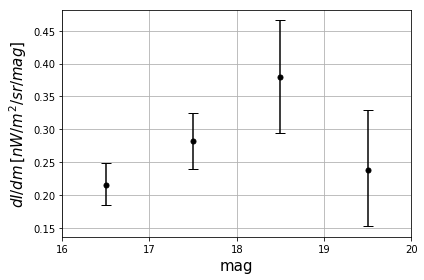

In [76]:
plt.errorbar([16.5,17.5,18.5,19.5], Itot_arr, [Itot_arr - Itot_arr_low, Itot_arr_high - Itot_arr],
              fmt='.', capsize=5, markersize=10, c='k')
plt.xlabel('mag',fontsize=15)
plt.ylabel(r'$dI/dm\, [nW/m^2/sr/mag]$',fontsize=15)
plt.xticks([16,17,18,19,20])
plt.grid()

plt.tight_layout()
plt.savefig('plots/Itot.png', dpi = 150, bbox_inches='tight')